# Libraries

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from ete3 import Tree, TreeNode, TreeStyle, NodeStyle, TextFace

# Algorithms

In [2]:
# The Moran simulation
def MoranSimulation(popultaion_size = int):

    # The number of generaions that will maximum be generated
    iterations = popultaion_size*popultaion_size*10

    # Creating the initial population
    population = np.zeros(popultaion_size, dtype=int)

    # An array to keep track of ancestry
    ancestry = np.zeros(2*iterations+1, dtype=int)

    # Runing the simulation
    next_id = 1

    for iteration in range(iterations):
        reprodice_index, death_index = random.sample(range(0,popultaion_size), 2)
        ancestry[next_id] = population[reprodice_index]
        population[death_index] = next_id
        next_id += 1
        ancestry[next_id] = population[reprodice_index]
        population[reprodice_index] = next_id
        next_id += 1    

    return list(population), iteration, ancestry

def TreeMaker(present_population = list ,present_time = int, ancestry = list, sample_size = 0):
    
    # Sampleing the population in a list
    if sample_size == 0 or sample_size == len(present_population):
        population_sample = present_population
        sample_size = len(population_sample)
    else:
        population_sample=random.sample(present_population, sample_size)

    # Names of the sampled individuals
    strings = [repr(i) for i in population_sample]
    # Ages of the sampled individuals
    ages = [present_time]*sample_size
    # Creating the tree using the newick format
    while len(population_sample)>1:
        # Chosing the youngest individual within the sampled population
        youngest = max(population_sample)
        index = population_sample.index(youngest)
        # Determining the father of the youngest
        mother  = ancestry[youngest]
        # Chaning the youngest to its father
        population_sample[index] = mother
        # Searching the sample for individuals with the same father
        indicies = [index for index,value in enumerate(population_sample) if value == mother] 
        # Should the sample have individuals with the same father tha newick string is formed 
        # and the individuals removed from the sample
        if len(indicies) > 1:
            mother_age = mother//2  #ids give the age of a node as: age = next_id // 2, e.g. 31//2==30//2==15
            smaller_index, larger_index = sorted(indicies)       
            strings[smaller_index] = \
                "("+strings[smaller_index]+":"+repr(ages[smaller_index]-mother_age)\
            +","+strings[larger_index]+":"+repr(ages[larger_index]-mother_age) + ")"
            ages[smaller_index]= mother_age
            population_sample.pop(larger_index)
            strings.pop(larger_index)
            ages.pop(larger_index)      

    newick_string = strings[0]+";"
    return newick_string

def CoalescentTimeCalculator(newick_string=str):
    # Creating the tree object using ete3 toolkit
    tree = Tree(newick_string)
    # Getting the leaves of the tree
    leaves = tree.get_leaves()
    # A list that will hold the coalescent times
    coalescent_times = []
    # cycling through the leaves and getting all their ancesotrs. Than cycling through their ancestors and calulaiing the distance between ancestor and leaf
    # if the distance is not in coalescent_time than we append it
    ancestors_list = []
    for leaf in leaves:
        ancestors = leaf.get_ancestors()
        for ancestor in ancestors:
            time = ancestor.get_distance(leaf)
            ancestor.add_features(coalescent_time = time)
            if ancestor not in ancestors_list:
                coalescent_times.append(time)
                ancestors_list.append(ancestor)
    coalescent_times.sort()
    return coalescent_times

# Running the simulations

In [3]:
population_size = 100
sample_size  = 10
filename1 = 'MoranStatistics.txt'
filename2 = "MoranNewickTrees.txt"

In [5]:
with open(filename1, "w") as f1, open(filename2, "w") as f2:
    f1.write(f"# This document contanins statistical data on Moran simulation \n# Population size: \t{population_size}\n# Sample size: \t{sample_size}\n# Coalescent times:\n")
    f2.write(f"# This document contains newick string of trees generated by Moran Simulations\n")
    for iteraion in range(100):
        present_population, present_time, ancestry = MoranSimulation(population_size )
        tree_string = TreeMaker(present_population, present_time, ancestry, sample_size)
        coalescent_times = CoalescentTimeCalculator(tree_string)
        f1.write("\t".join(str(num) for num in coalescent_times)+"\n")
        f2.write(tree_string+"\n")

# Calcaulating and taking the average of the waiting times

In [4]:
# Getting the statiscal and calculating the waiting times:
data = np.loadtxt(filename1)
waiting_times_list = []
for array in data:
    current_time = 0
    temp_list = []
    for index in range(len(array)):
        temp_list.append(array[index]-current_time)
        current_time = array[index]
    waiting_times_list.append(temp_list)

# Gathering together the datas that belong to the same coalescent event:
waiting_times_array = np.array(waiting_times_list)
waiting_times = []
for index in range(0, 9):
    waiting_times.append(waiting_times_array[:,index])

# Averaging the data
average_waiting_times = []
for times in waiting_times:
    average = np.average(times)
    average_waiting_times.append(average)

# Calculating the theoretical waiting time of the Moran simulations

For this equation 32 is used:$$E(T(r)) = \frac{N(N-1)}{r(r-1)}\delta_{M}$$ where $\delta_{M} = 1$

In [5]:
def TheoValue(r):
    expected_theoretical_value = (population_size*(population_size-1))/(r*(r-1))
    return expected_theoretical_value

theoretical_values = []
for i in range(2,sample_size+1):
    theoretical_values.append(TheoValue(i))
theoretical_values.reverse()

# Calculating the error between simulated data and theoretical value

In [6]:
error = []
for i in range(len(theoretical_values)):
    error.append(abs(theoretical_values[i]- average_waiting_times[i])/theoretical_values[i])

# Calculatting the standard deviation in the simulated data

In [53]:
std_list = []
for line in waiting_times:
    std_list.append(np.std(line))

[121.75443975477855,
 119.43998116208826,
 154.56969301903916,
 225.37419794643753,
 326.9786957891905,
 611.2495002860943,
 940.9213410269745,
 1657.8079315469568,
 5862.538247372037]

# Ploting the theoretical and simulated Waiting times

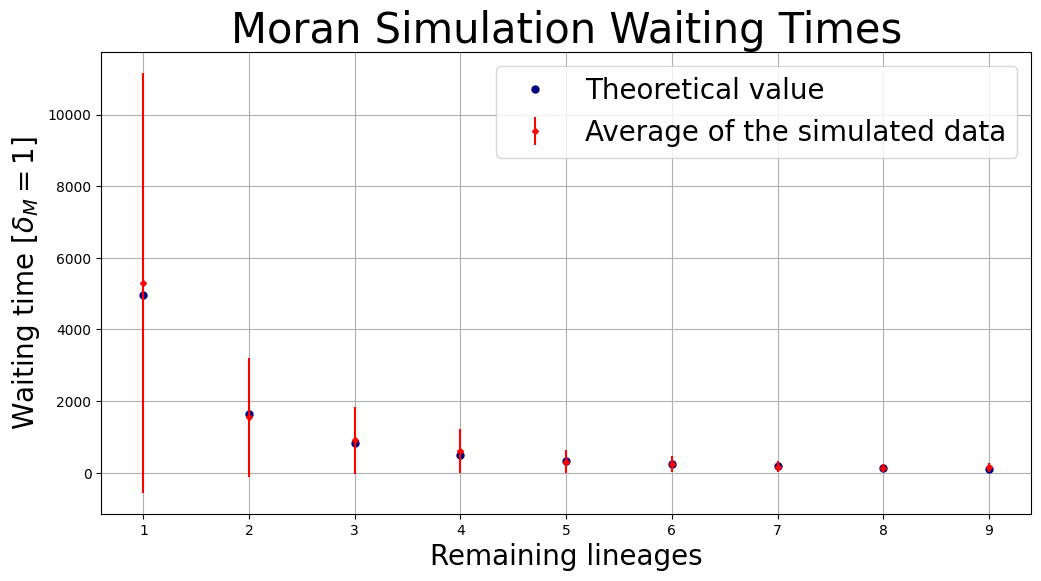

In [66]:
number = list(np.arange(1, sample_size))
number.reverse()
plt.figure(figsize=(12,6))
plt.plot(number, theoretical_values, marker = "o",ms = 5, ls = "", color = "navy", label = "Theoretical value")
plt.errorbar(number, average_waiting_times, yerr= std_list, marker = "D", ls = "",ms = 3, color = "red", label = "Average of the simulated data")
plt.legend(fontsize = 20)
plt.xlabel("Remaining lineages", fontsize = 20)
plt.ylabel("Waiting time [$\delta_M = 1$]", fontsize = 20)
plt.grid()
plt.title("Moran Simulation Waiting Times", fontsize = 30)
plt.savefig("Waiting_times.png")

# Calculating the average of the Coalescent times

In [27]:
average_coalescent_times = []
for index in range(0,sample_size-1):
    average_coalescent_times.append(np.average(data[:,index]))

In [28]:
Theoretical_coalescent_times = [theoretical_values[0]]
for index in range(1, len(theoretical_values)):
    Theoretical_coalescent_times.append(Theoretical_coalescent_times[-1]+theoretical_values[index])

In [29]:
# The continous function of the change of remining lines of descent
def RemainingLines(T,N, n):
    nominator = n
    denominator = (T*n)/(N**2)+1
    return  nominator/denominator

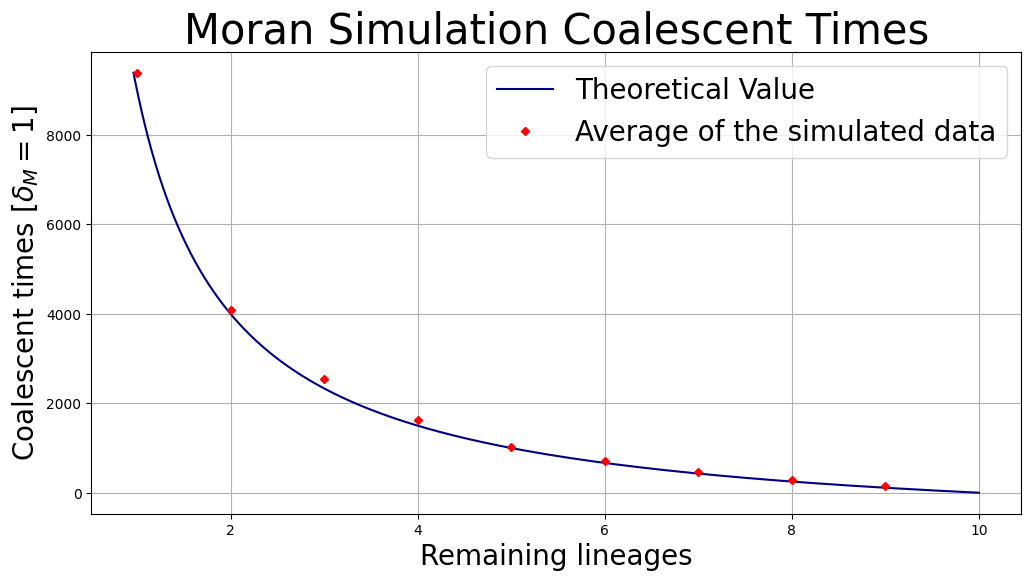

In [46]:
plt.figure(figsize=(12,6))
times = np.linspace(0, average_coalescent_times[-1], 1000)
plt.plot(RemainingLines(times, 100, 10), times, color = "navy", label = "Theoretical Value")
plt.plot(number, average_coalescent_times,  marker = "D",ms = 4, ls = "", color = "red", label = "Average of the simulated data")
plt.legend(fontsize = 20)
plt.ylabel("Coalescent times [$\delta_M = 1$]", fontsize = 20)
plt.xlabel("Remaining lineages", fontsize = 20)
plt.grid()
plt.title("Moran Simulation Coalescent Times", fontsize = 30)
plt.savefig("Coalescent_times.png")